<div style="display: flex; align-items: center; padding: 20px; background-color: #f0f2f6; border-radius: 10px; border: 2px solid #007bff;">
    <img src="../logo.png" style="width: 80px; height: auto; margin-right: 20px;">
    <div style="flex: 1; text-align: left;">
    <h1 style="color: #007bff; margin-bottom: 5px;">GLY 6739.017S26: Computational Seismology</h1>
    <h3 style="color: #666;">Notebook 08: Filters</h3>
    <p style="color: red;"><i>Glenn Thompson | Spring 2026</i></p>
    </div>
</div>

# Filters in Seismology with ObsPy

This notebook is a hands-on introduction to filtering, using **ObsPy** idioms (`Trace.filter()`).

You will learn:
- What **highpass**, **lowpass**, and **bandpass** filters do
- The difference between **one-way (causal)** and **two-way (zero-phase / acausal)** filtering in ObsPy (`zerophase=False/True`)
- Why **zero-phase does not “shift” waveforms** but **can smear energy before an onset** (pre-ringing)
- How filter **order/corners** affects cutoff sharpness and ringing
- How to visualize outputs in the **time domain** and **frequency domain**
- A wrap-up section on **analog vs digital** thinking (what’s different in practice)

> We speak with *analog intuition* (frequency content, phase, causality),  
> but the code applies **digital filters** to sampled data (as you actually do in seismology).


This is a very solid starting section already — it just needs a bit more **conceptual scaffolding** so that it naturally leads into the causal vs zero-phase discussion you wrote next.

Here is a refined version that:

* keeps your structure,
* sharpens the definitions,
* and explicitly sets up the transition to timing/phase effects.

You can drop this straight in above Section 3.

---

## 1) Filter types

In seismology, filtering is usually described in terms of **which frequencies we keep** and **which we suppress**.

The three most common filter types are:

---

### Lowpass

Passes **low frequencies**, attenuates high frequencies.

* Use for:

  * removing high-frequency noise
  * smoothing waveforms
  * isolating long-period or very low-frequency signals

Typical examples:

* LP events
* tilt-like or drift-dominated signals

---

### Highpass

Passes **high frequencies**, attenuates low frequencies.

* Use for:

  * removing offsets, drift, and long-period trends
  * emphasizing sharp arrivals (P, S, explosions)

Typical examples:

* picking P and S arrivals
* suppressing instrument drift or temperature effects

---

### Bandpass

Passes a **restricted range** of frequencies.

* Use for:

  * isolating the band where the **signal-to-noise ratio is highest**
  * separating overlapping signal types

Typical examples:

* P-band vs S-band
* LP-band vs tremor-band

---

### Analog intuition vs digital practice

In *analog* terms, we usually describe filters by:

* frequency content
* amplitude response
* phase response

But in *practice*, we implement filters:

* digitally
* on **sampled data**
* using discrete-time algorithms

This has two important consequences:

1. Filters affect **amplitude and frequency**, as expected.
2. Filters also affect **phase and timing** — sometimes in subtle ways.

In the next section, we will see that:

> Filtering does not only change *what frequencies* are present.
> It can also change *when energy appears in time*.

This leads to a critical distinction between:

* **one-way (causal)** filtering, and
* **two-way (zero-phase)** filtering.

> This matters directly for arrival picking, detection algorithms, and any analysis that depends on precise timing.

### 3) ObsPy filtering: one-way (causal) vs two-way (zero-phase)

ObsPy’s `Trace.filter()` supports two fundamentally different ways of applying a digital filter:

* `zerophase=False` → **one-way (causal)** IIR filtering
* `zerophase=True`  → **two-way forward/backward (zero-phase, acausal)** filtering

The parameter `corners` controls the **steepness** of the filter’s frequency response:

* higher `corners` → sharper cutoff
* but also → more ringing in the time domain

This is sometimes called the *order* of the filter.

---

### How zero-phase filtering is constructed

A one-way (causal) filter has an **asymmetric impulse response in time**:
it only depends on past samples.

A zero-phase filter is constructed by:

1. applying the filter forward in time, and then
2. applying the *same filter backward* to the result.

This is equivalent to convolving the signal with a filter that is:

* the original impulse response
* convolved with its **time-reversed version**

ObsPy does this automatically when `zerophase=True`.

The result is an **effective impulse response that is symmetric in time**.

---

### Any filter distorts the signal

Every filter changes the waveform in a specific way:

* amplitudes change
* phases change
* timing of features can change

Some distortions are acceptable or even useful.
Some are dangerous if you are not aware of them.

This leads to the key concept: **onset smearing**.

---

### Onset smearing: causal vs zero-phase

* **One-way (causal) filters** typically introduce **group delay**

  * arrivals appear later in time
  * onsets can be slightly smeared

* **Two-way (zero-phase) filters** avoid any *net* phase delay

  * the waveform is not shifted later overall
  * but they can produce **symmetric ringing** around sharp features

Forward–backward filtering is **acausal**.

Because its effective impulse response is **symmetric in time**, it can create
**pre-ringing**:

* energy appears *before* the true physical onset

So:

* **Causal filters**

  * do *not* create pre-onset energy
  * but they can **delay** the arrival

* **Zero-phase filters**

  * do *not* delay the waveform overall
  * but they can **smear energy before the onset**

---

### Demonstration

Let’s demonstrate this with a very sharp onset and compare:

* raw signal
* causal filtering
* zero-phase filtering

and see how the apparent arrival time changes.



In [12]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import Stream, Trace, UTCDateTime
from scipy.signal import spectrogram

# P-like: a short Ricker wavelet at 10 s
def ricker(t, t0, f0):
    tau = t - t0
    a = (np.pi*f0*tau)**2
    return (1 - 2*a) * np.exp(-a)

def plot_stream_spectrograms(
    st,
    starttime=None,
    endtime=None,
    fmin=0.0,
    fmax=None,
    nperseg=None,
    noverlap=0.95,
    detrend="constant",
    window="hann",
    scaling="density",
    mode="psd",
    db=True,
    clim=None,              # (vmin, vmax) in dB (or linear if db=False)
    common_clim=True,       # same color limits across traces
    cmap="viridis",
    show_waveform=False,    # add waveform above each spectrogram
    figsize=(12, 2.6),
):
    """
    Plot spectrograms for all traces in an ObsPy Stream as stacked subplots.

    Zooming:
    - In Jupyter, matplotlib toolbar zoom/pan works.
    - You can also set starttime/endtime and fmin/fmax.

    Notes:
    - Times are plotted as seconds from the chosen starttime.
    - Uses scipy.signal.spectrogram; good control over FFT params.
    """
    if len(st) == 0:
        raise ValueError("Stream is empty")

    # Work on a copy so we don't mutate the caller's stream
    st2 = st.copy()

    # Decide time window
    if starttime is None:
        starttime = min(tr.stats.starttime for tr in st2)
    if endtime is None:
        endtime = max(tr.stats.endtime for tr in st2)

    st2.trim(starttime=starttime, endtime=endtime, pad=True, fill_value=0.0)

    # Choose fs and FFT params per trace (we compute individually)
    specs = []  # (f, t, Sxx_db or linear)
    titles = []

    for tr in st2:
        x = tr.data.astype(np.float64)
        fs = float(tr.stats.sampling_rate)

        if nperseg is None:
            # rule of thumb: ~2 s window, but at least 256 samples
            nperseg_i = max(int(fs * 2.0), 256)
        else:
            nperseg_i = int(nperseg)

        noverlap_i = int(noverlap * nperseg_i)

        f, tt, Sxx = spectrogram(
            x,
            fs=fs,
            window=window,
            nperseg=nperseg_i,
            noverlap=noverlap_i,
            detrend=detrend,
            scaling=scaling,
            mode=mode,
        )

        # Convert time axis to seconds from starttime
        # spectrogram's tt is seconds from trace start (which equals our starttime after trim)
        # so it's already relative to starttime.
        if db:
            S = 10.0 * np.log10(np.maximum(Sxx, 1e-20))
        else:
            S = Sxx

        specs.append((f, tt, S, tr))
        label = getattr(tr.stats, "label", None)
        titles.append(label if label else f"{tr.id}")

    # Decide fmax default (Nyquist min across traces)
    if fmax is None:
        fmax = min(0.5 * float(tr.stats.sampling_rate) for _, _, _, tr in specs)

    # Determine common color limits
    if common_clim:
        all_vals = []
        for f, tt, S, tr in specs:
            fm = (f >= fmin) & (f <= fmax)
            all_vals.append(S[fm, :])
        all_vals = np.concatenate([a.ravel() for a in all_vals])
        if clim is None:
            # robust range: 2–98 percentile
            vmin, vmax = np.percentile(all_vals, [2, 98])
        else:
            vmin, vmax = clim
    else:
        vmin = vmax = None  # per-trace below

    n = len(specs)
    rows = n
    extra = 1 if show_waveform else 0
    total_rows = rows * (1 + extra)

    fig, axes = plt.subplots(
        nrows=total_rows,
        ncols=1,
        figsize=(figsize[0], figsize[1] * total_rows),
        sharex=True,
        constrained_layout=True,
    )

    if total_rows == 1:
        axes = [axes]

    # Helper: find axis index for each trace
    def ax_idx(i, is_wave):
        if show_waveform:
            base = i * 2
            return base if is_wave else base + 1
        return i

    mappable = None

    for i, (f, tt, S, tr) in enumerate(specs):
        # Frequency mask for plotting
        fm = (f >= fmin) & (f <= fmax)
        f_plot = f[fm]
        S_plot = S[fm, :]

        # Per-trace clim if needed
        if not common_clim:
            if clim is None:
                vmin_i, vmax_i = np.percentile(S_plot.ravel(), [2, 98])
            else:
                vmin_i, vmax_i = clim
        else:
            vmin_i, vmax_i = vmin, vmax

        # Optional waveform
        if show_waveform:
            axw = axes[ax_idx(i, True)]
            t_axis = np.arange(tr.stats.npts) / float(tr.stats.sampling_rate)
            axw.plot(t_axis, tr.data)
            axw.set_ylabel("amp")
            axw.set_title(titles[i])
            axw.grid(True, alpha=0.25)

        axs = axes[ax_idx(i, False)]
        # Use pcolormesh for zoomable plots
        mappable = axs.pcolormesh(tt, f_plot, S_plot, shading="auto",
                                  vmin=vmin_i, vmax=vmax_i, cmap=cmap)
        axs.set_ylabel("Hz")
        if not show_waveform:
            axs.set_title(titles[i])

        # Apply y-limits explicitly for zoom framing
        axs.set_ylim(fmin, fmax)

    axes[-1].set_xlabel(f"Time since {starttime} (s)")

    # Add one shared colorbar
    cbar = fig.colorbar(mappable, ax=axes, location="right", pad=0.01, shrink=0.95)
    cbar.set_label("Power (dB)" if db else "Power")

    return fig, axes

def plot_stream(st, title="", xlabel="Time (s)", ylabel="Amplitude", xlim=None):
    fig, ax = plt.subplots(figsize=(10, 3))
    for tr in st:
        t = tr.times()
        x = tr.data
        ax.plot(t, x, label=tr.stats.label)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    if xlim is not None:
        ax.set_xlim(*xlim)
    plt.legend()
    plt.show()

def make_trace(x, fs, starttime=None):
    tr = Trace(data=np.asarray(x, dtype=np.float64).copy())
    tr.stats.sampling_rate = float(fs)
    tr.stats.starttime = UTCDateTime(0) if starttime is None else starttime
    return tr

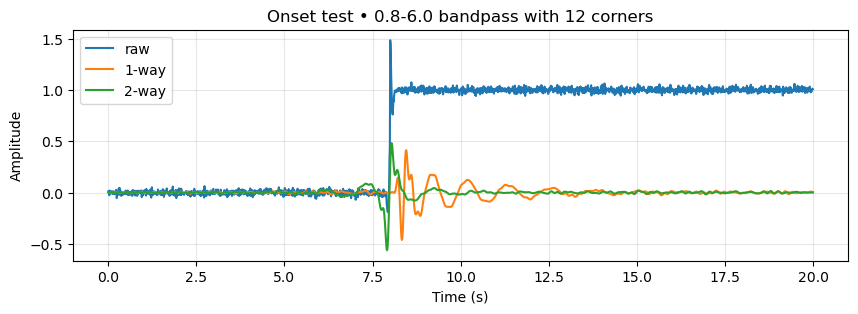

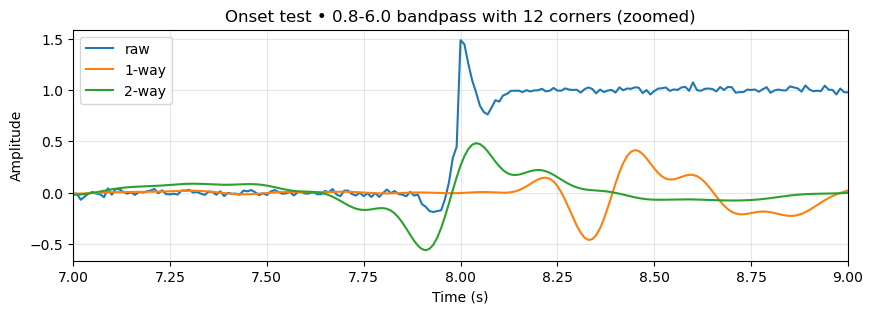

In [14]:
# Build a very sharp onset: a step + a short pulse, with some noise
fs = 100.0
t2 = np.arange(0, 20, 1/fs)
x2 = np.zeros_like(t2)

t_on = 8.0
x2[t2 >= t_on] += 1.0              # step onset
x2 += 0.5 * ricker(t2, t_on, 6.0)  # sharp pulse on top
x2 += 0.02 * np.random.default_rng(1).standard_normal(len(t2))

tr_on = make_trace(x2, fs)
tr_on.stats['label'] = 'raw'

# Apply bandpass both ways to make ringing obvious
corners_test = 12
tr_on_1way = tr_on.copy().filter("bandpass", corners=corners_test, zerophase=False, freqmin=bp_fmin, freqmax=bp_fmax)
tr_on_1way.stats['label'] = '1-way'

tr_on_2way = tr_on.copy().filter("bandpass", corners=corners_test/2, zerophase=True, freqmin=bp_fmin, freqmax=bp_fmax)
tr_on_2way.stats['label'] = '2-way'

st = Stream(traces=[tr_on, tr_on_1way, tr_on_2way])

bp_fmin, bp_fmax = 0.8, 6.0

plot_stream(st, title=f"Onset test • {bp_fmin}-{bp_fmax} bandpass with {corners_test} corners")#, xlim=(7, 9))
plot_stream(st, title=f"Onset test • {bp_fmin}-{bp_fmax} bandpass with {corners_test} corners (zoomed)", xlim=(7, 9))

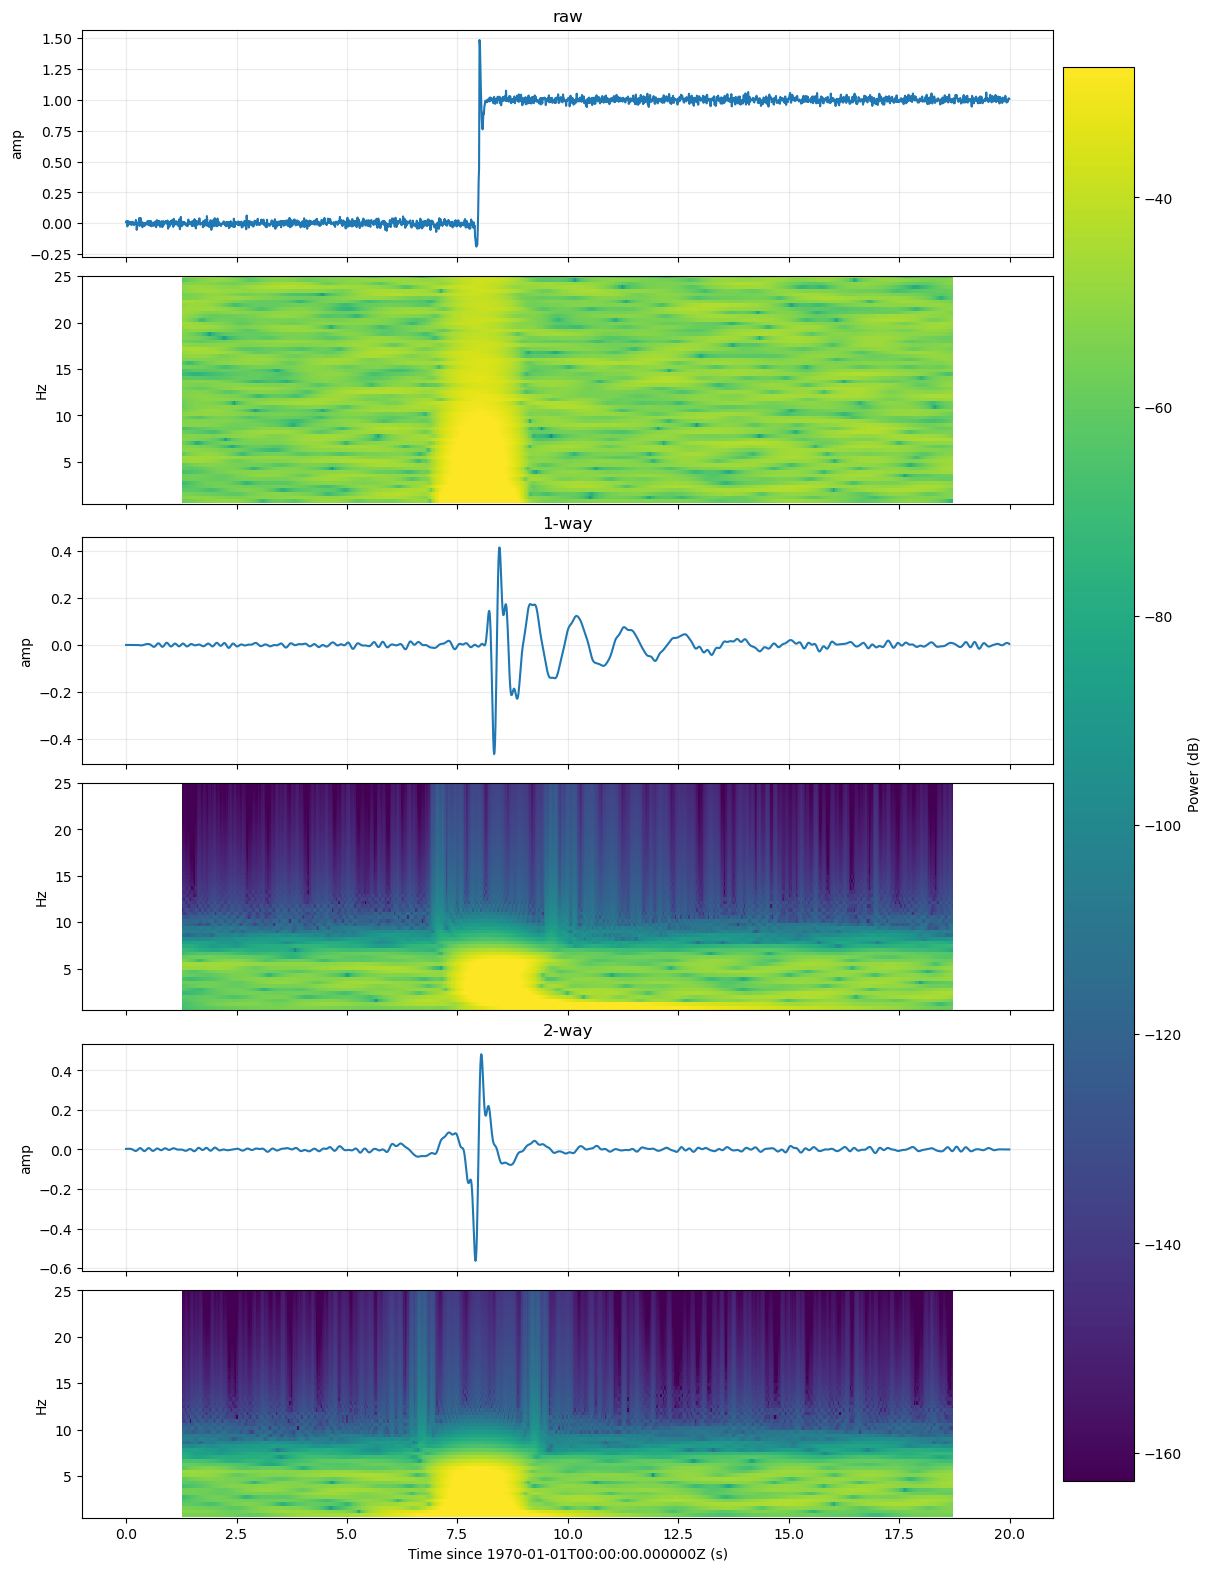

In [13]:
fig, axes = plot_stream_spectrograms(
    st,
    fmin=0.5,
    fmax=25,
    show_waveform=True, 
    noverlap=0.99  # optional
)
plt.show()

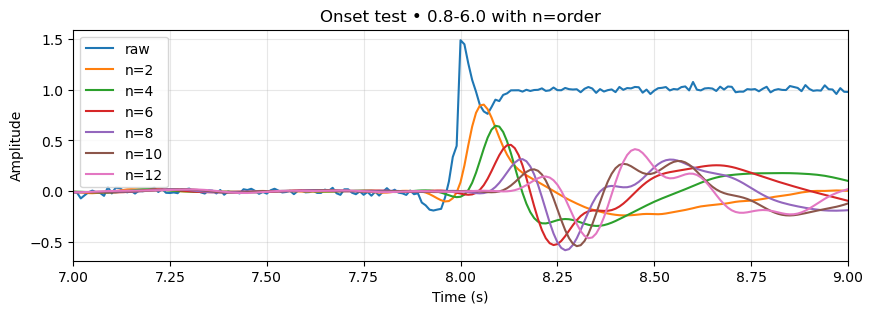

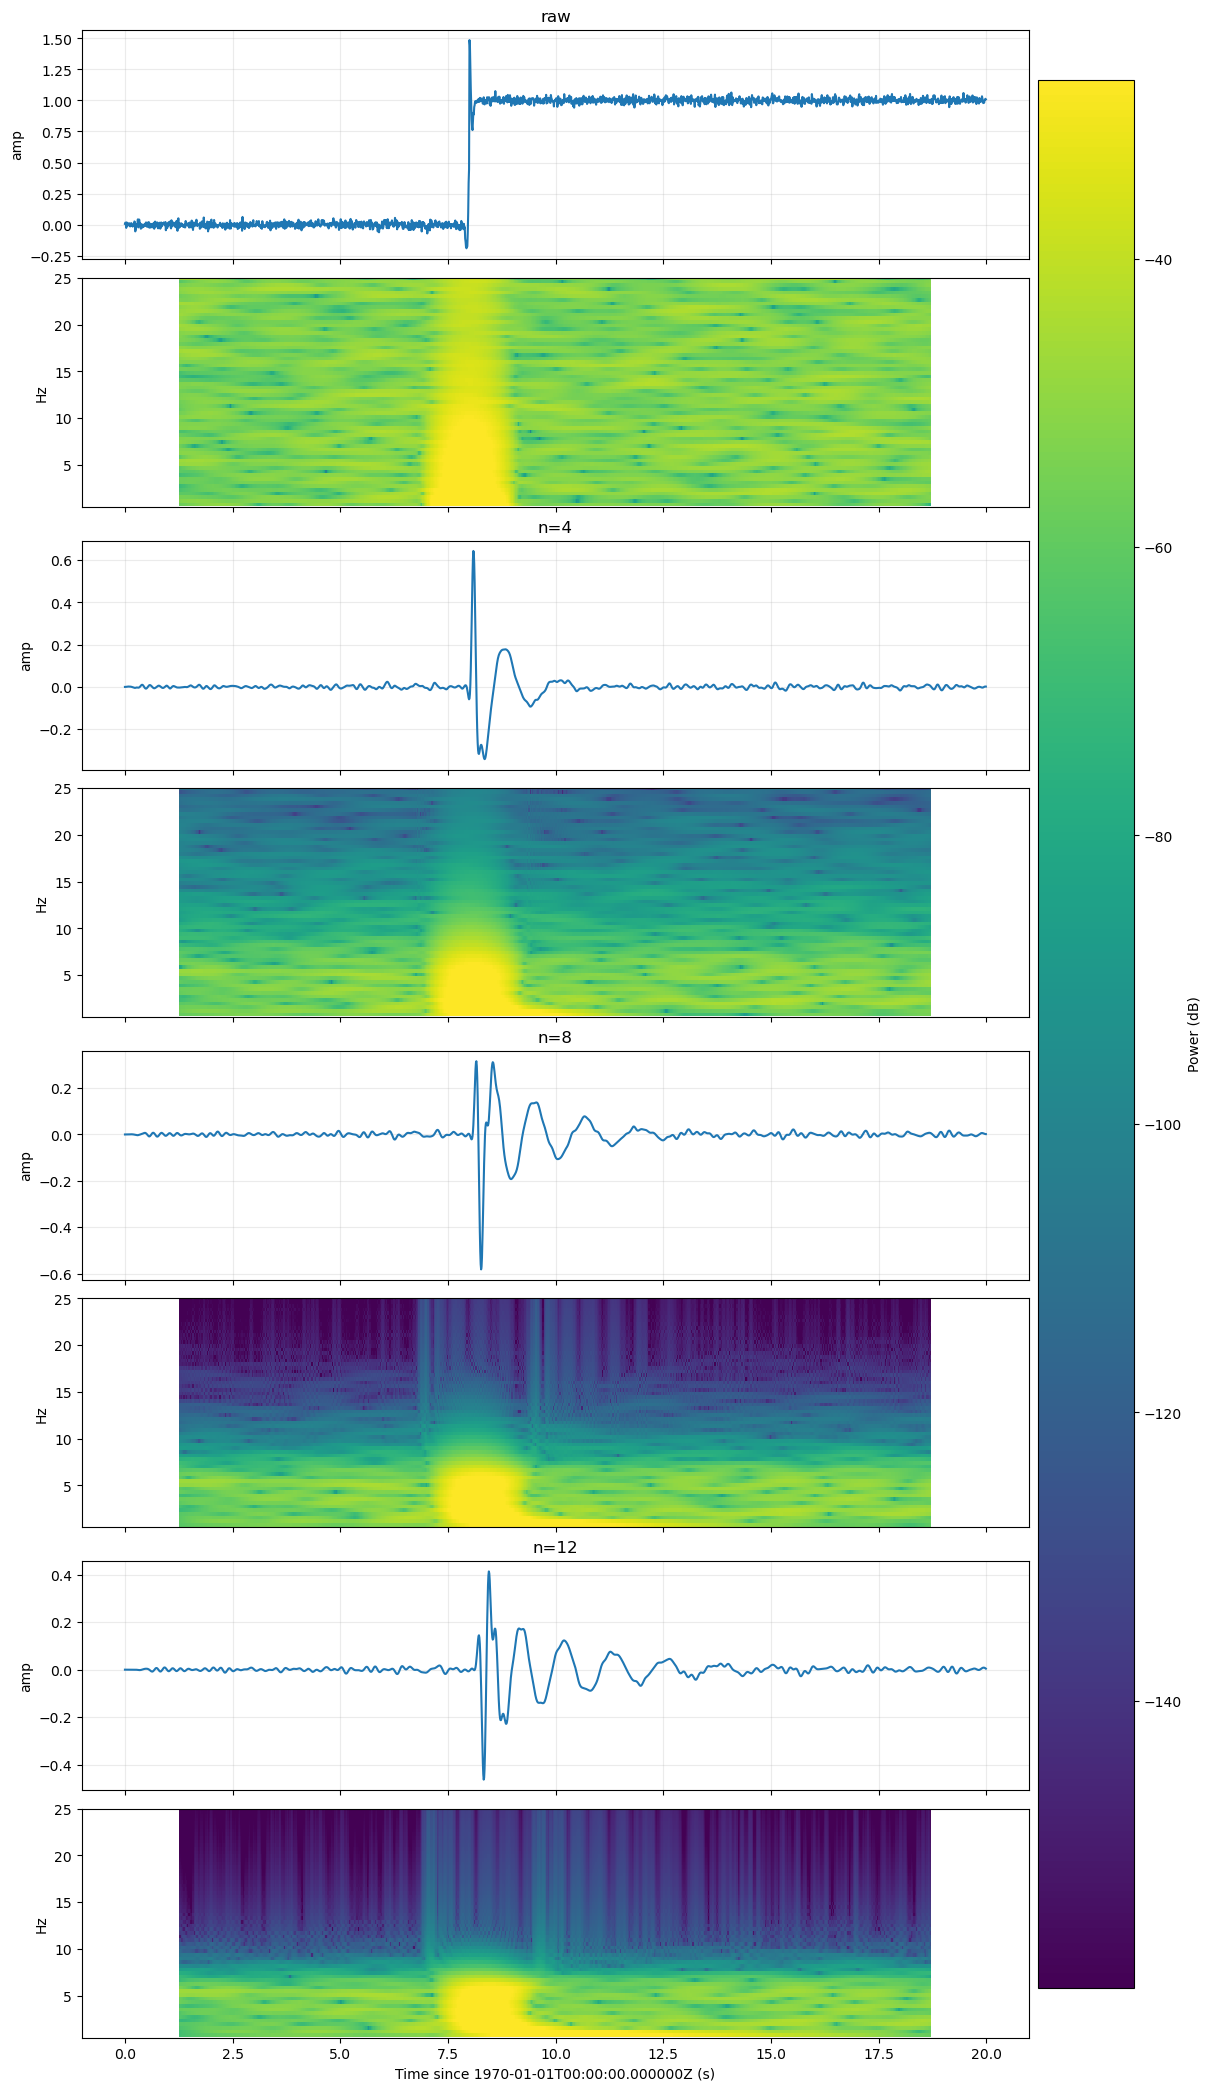

In [15]:
st2 = Stream(traces=[tr_on])
for corners_test in range(2,13,2):
    tr_tmp = tr_on.copy().filter("bandpass", corners=corners_test, zerophase=False, freqmin=bp_fmin, freqmax=bp_fmax)
    tr_tmp.stats['label'] = f'n={corners_test}'
    st2.append(tr_tmp)

plot_stream(st2, title=f"Onset test • {bp_fmin}-{bp_fmax} with n=order", xlim=(7, 9))

fig, axes = plot_stream_spectrograms(
    Stream(traces=st2[::2]),
    fmin=0.5,
    fmax=25,
    show_waveform=True, 
    noverlap=0.99  # optional
)
plt.show()

### Takeaway for arrival picking and waveform interpretation

Filtering choices matter directly for **timing**, not just for appearance.

If you are picking **first-break** arrivals (the earliest physical onset):

* **Causal filtering** is conceptually safer

  * it cannot create energy before the true onset
  * but it can **delay** the arrival by a frequency-dependent amount

If you are doing **offline alignment**, **template matching**, or making clean-looking plots:

* **Zero-phase filtering** is often preferred

  * it avoids net phase distortion
  * but it can create **pre-ringing** (energy before the true onset),
    especially for narrow bands or high-order filters

A useful rule of thumb:

> **Causal filters preserve causality but introduce delay.**
> **Zero-phase filters avoid net delay but can smear energy before the onset.**

Neither choice is “right” in all cases — the choice depends on:

* whether timing accuracy or waveform symmetry matters more, and
* whether you are working in real time or offline.

---

### Filter order (`corners`): sharper cutoff vs more ringing

The parameter `corners` controls how steeply the filter transitions between passband and stopband.

What to notice:

* Higher `corners` → **sharper cutoff** (better frequency separation)
* Higher `corners` → **more ringing** in the time domain
* Two-way filtering makes ringing **more symmetric and more visible**

In practice:

* start with modest values (e.g., `corners = 2–4`)
* avoid very narrow bands unless you really need them
* always inspect the time-domain effect, not just the frequency response

---

### Conceptual wrap-up: what filtering really does

By now you should be comfortable with three key ideas:

1. Filtering changes **which frequencies** are present.
2. Filtering also changes **phase and timing**.
3. The timing effects depend on:

   * causal vs zero-phase
   * filter order
   * bandwidth

This leads naturally to the convolutional view:

$$
d(t) = s(t) * g(t) * i(t)
$$

where:

* s(t) = source
* g(t) = path + site response
* i(t) = instrument + digitizer response

The filters you apply in software are **only one part** of a longer chain of filtering that begins in the hardware.

